In [30]:
%pylab --no-import-all

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [47]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory as btf

In [48]:
def load_data(filename):
    struct = loadmat(str(filename))
    data, *stuff = struct['dataStruct'][0][0]
    sampling_frq, length, chnls, *timestamp = \
        (a.squeeze() if a.size > 1 else np.asscalar(a) for a in stuff)
    duration = length / sampling_frq
    Nch = len(chnls)
    timestamp = int(timestamp[0]) if len(timestamp) else None
    return data.T, duration, sampling_frq, Nch, timestamp



def plot_channels(ax, data, fs=400, maxpoints=1e4, **kws):
    '''Channel time series plot'''
    #plot no more that requested number of points per TS
    Nch, Ndat = data.shape
    every = Ndat // maxpoints
    data = data[:, ::(int(every) or 1)]

    #calculate display scale
    scale = kws.get('scale')
    if scale is None:
        #determine plot spacing from data percentiles
        q = (0.1, 99.9)
        scale = np.round(np.percentile(data, q, 1).ptp(0).max(), -2)
    spaces = scale * np.arange(Nch)[:,None]
    dx = data + spaces

    #calculate time scale
    tscale = kws.get('timescale', 'm')
    tfact = {'h':1/60*60, 'm':1/60, 's':1}[tscale]
    t = np.arange(data.shape[-1]) * every * tfact / fs

    #plot
    pl = ax.plot(t, dx.T, 'b-')

    #make scale bar
    if kws.get('scalebar', True):
        x = np.r_[[-0.025]*2]
        y = (np.r_[0, 1] - 0.5) * scale
        opt = dict(transform=btf(ax.transAxes, ax.transData),
                   clip_on=False)
        ax.plot(x, y, 'k-', marker='_', **opt)
        ax.text(x[0], y[0], '%i mV' % scale,
                va='bottom', ha='right', rotation=90, **opt)

    #setup ticks
    tickspace = tfact * 600 #tick every 10 min
    nticks = round(t[-1] / tickspace) + 1
    if nticks > 3:
        xticks = np.arange(nticks) * tickspace
        ax.set_xticks(xticks)

    ax.set_xlim(0, t[-1])
    ax.set_ylim(np.multiply((-0.5, Nch-0.5), scale))
    ax.set_yticks(spaces)
    ax.set_yticklabels(np.arange(1, Nch+1).astype(str))

    ax.set_xlabel('Time (%s)' % tscale)
    ax.set_ylabel('Channel')
    title = kws.get('title')
    #files = kws.get('files')
    if title:
        ax.set_title(title)

    ax.grid(axis='x', lw=2, color='0.5')

    return data, t, pl

In [44]:
filename = '/media/KINGSTON/EEG/data/train_1/1_1_0.mat'
data, *stuff, timestamp = load_data(filename)

In [45]:
data.shape  # each clip contains 240000 points per channel

(16, 240000)

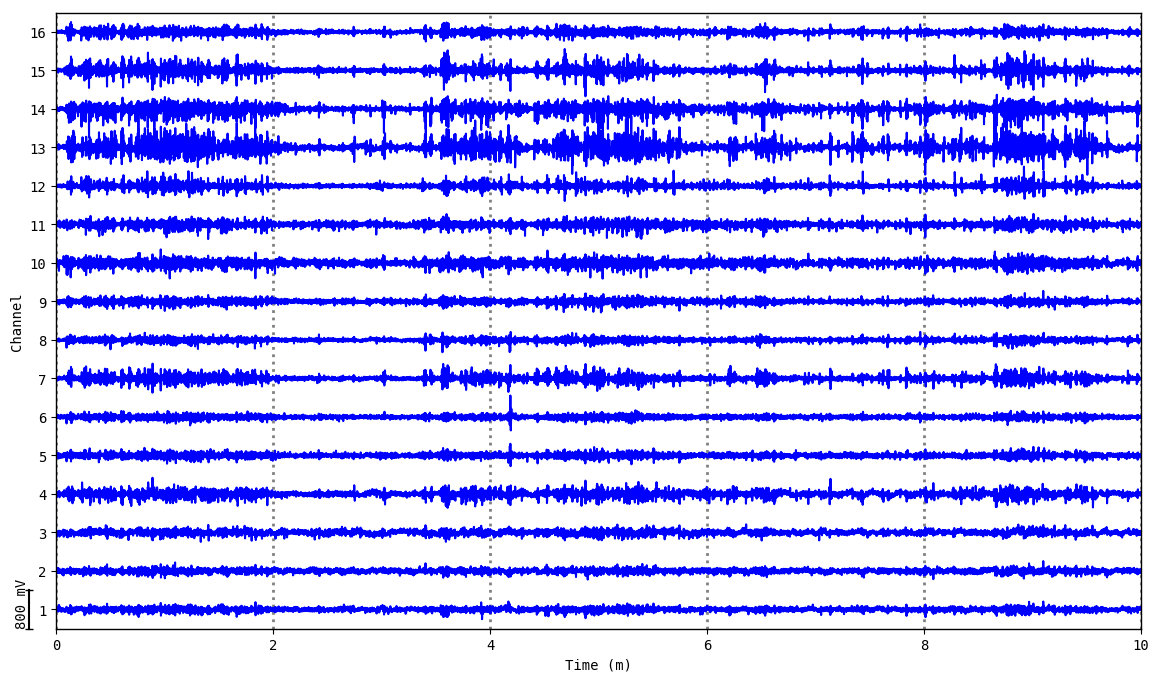

In [49]:
fig, ax = plt.subplots(figsize=(14,8))
plot_channels(ax, data)
fig